In [1]:
from visualization_fct import *
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import scale

# from bokeh.plotting import output_file, show, save
# from bokeh.mpl import to_bokeh

from bokeh.resources import CDN
from bokeh.embed import file_html
from bokeh.plotting import output_notebook, show, output_file
output_notebook()

import matplotlib.pyplot as plt  # , mpld3
import pyfits


np.random.seed(0)

# for now, no ratio in data (no rates A, B or C in this dataset)

only_flux = True
scale_flux = False

hdulist = pyfits.open('../iirc_data/all_data_for_ml.fits')
data = hdulist[1].data

### flux attribute:
# we need to change the byte order for fits -> dataframe:
if scale_flux:
    data_fr = pd.DataFrame(scale(data['flux'].byteswap().newbyteorder()))
else:
    data_fr = pd.DataFrame(data['flux'].byteswap().newbyteorder())
# convert attributes to str:
flux_attr = [str(j) for j in data_fr.columns]
data_fr.columns = flux_attr

#### average energy attribute:
en = (data['en_lo'].byteswap().newbyteorder() + data['en_hi'].byteswap().newbyteorder()) / 2.
data_fr_en = pd.DataFrame(en)
# convert attributes to str:
en_attr = ['en_' + str(j) for j in data_fr_en.columns]
data_fr_en.columns = en_attr

### other attributes:
names = [data.columns[j].name for j in range(len(data.columns))]
# rm str attribute:
names.remove('block')
names.remove('orbitalphase')
names.remove('smoothorbitalphase')
# rm useless attributes or already in:
names.remove('en_lo')  # already in
names.remove('en_hi')  # already in
names.remove('flux')  # already in
names.remove('flux_err')  # error term
# also remove error terms, tstart and tstop:
#names.remove('rms1')
#names.remove('rms2')
#names.remove('rms3')
#names.remove('rms4')
names.remove('tstart')
names.remove('tstop')

data_fr2 = pd.DataFrame({name: data[name].byteswap().newbyteorder()
                         for name in names})


data_fr = pd.concat([data_fr, data_fr2, data_fr_en], axis=1)

# rm the rows with nan values:
data_fr = data_fr.dropna()

# rm too large values except for the orbits, 'gamma' and energy attr:
unthresholded_attr = ['orbitalphase', 'smoothorbitalphase','gamma'] + en_attr
data_thr = mask(data_fr, unthresholded_attr)

# labels from gamma as in the paper:
a = np.array(data_thr['gamma'])
y = (a > 2.5).astype('int') + (a > 2).astype('int')

# define X:
col_X = list(data_thr.columns)
col_X.remove('gamma')
for i in range(len(en_attr)):
    col_X.remove(en_attr[i])

X = np.concatenate([np.array(data_thr[name]).reshape(-1, 1) for name in col_X], axis=1)
X_flux = np.concatenate([np.array(data_thr[name]).reshape(-1, 1) for name in flux_attr], axis=1)

if only_flux:
    X = X_flux

Loading BokehJS ...

In [2]:
data_thr.columns
X_flux.shape

(1947, 78)

In [3]:
# make video / widget of showing spectra over time
import matplotlib.animation as animation

En = np.concatenate([np.array(data_fr_en[name]).reshape(-1, 1) for name in data_fr_en.columns], axis=1)
colors = ['red', 'blue', 'yellow']

#%matplotlib auto  #  'osx', 'qt4', 'qt5', 'gtk3', 'wx', 'qt', 'gtk', 'tk'

fig, ax = plt.subplots()

#line, = ax.plot(En[0, :], X_flux[0, :])
line, = ax.plot(range(X_flux.shape[1]), X_flux[0, :])

def animate(i):
    # line.set_xdata(En[i, :])  # update the data
    line.set_ydata(X_flux[i, :])   # update the data
    line.set_color(colors[y[i]])
    return line,


## Init only required for blitting to give a clean slate.
#def init():
#    line.set_ydata(np.ma.array(x, mask=True))
#    return line,

ani = animation.FuncAnimation(fig, animate, np.arange(1, 2000), #init_func=init,
                              interval=25, blit=True)
plt.show()


#ani.save('spectra_over_time.mp4', writer = 'mencoder', fps=30, extra_args=['-vcodec', 'libx264'])

In [4]:
# visualize datapoints by plotting spectrum multiplied by energy (en_hi + en_lo)/2

fig, ax = plt.subplots()
#plt.axes(xlim=(0, 1e-6), ylim=(0, 80))

line, = ax.plot(En[0, :], X_flux[0, :] * En[0, :])
#line, = ax.plot(range(X_flux.shape[1]), X_flux[0, :] * En[0, :])

def animate(i):
    line.set_xdata(En[i, :])  # update the data
    line.set_ydata(X_flux[i, :] * En[i, :])   # update the data
    line.set_color(colors[y[i]])
    return line,


# Init only required for blitting to give a clean slate.
def init():
    line.set_xdata(En[0, :])
    line.set_ydata(X_flux[0, :] * En[0, :])
    line.set_color(colors[y[0]])
    return line,

ani = animation.FuncAnimation(fig, animate, np.arange(1, 2000), init_func=init,
                              interval=25, blit=True)
plt.show()

In [5]:
lda = LDA(n_components=2).fit(X, y)
preds = lda.predict(X)
X_lda = lda.transform(X)
X_lda

/home/nicolas/anaconda2/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:457: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


array([[-1.58658056, -0.09451231],
       [-1.83840254, -0.00896516],
       [-1.60037007, -0.01951903],
       ..., 
       [ 7.705853  ,  1.58098794],
       [ 7.8472169 ,  1.76587232],
       [ 7.40069462,  1.71674549]])

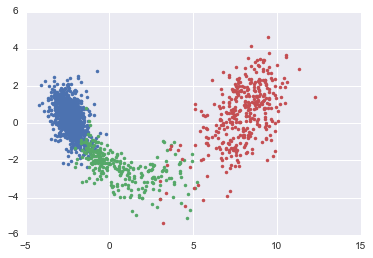

In [6]:
%matplotlib inline
clr = np.array(['blue', 'red', 'yellow'])
for j in range(3):
    plt.plot(X_lda[:, 0][y==j], X_lda[:, 1][y==j], '.')
plt.show()

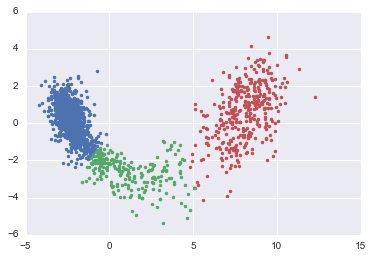

In [7]:
for j in range(3):
    plt.plot(X_lda[:, 0][preds==j], X_lda[:, 1][preds==j], '.')
plt.show()

In [8]:
lda.explained_variance_ratio_

array([ 0.9467502,  0.0532498])

<IPython.core.display.Javascript object>


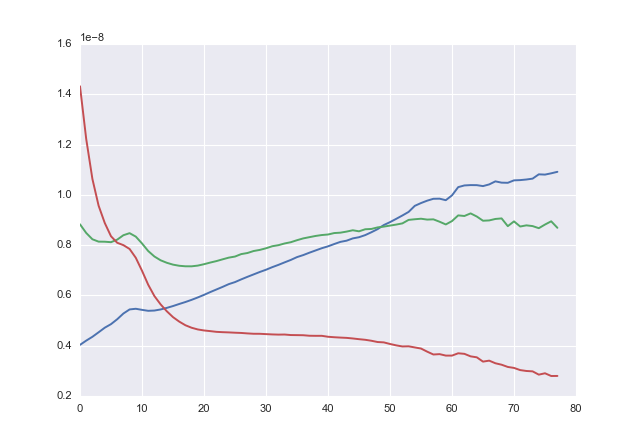

In [21]:
%matplotlib notebook
plt.figure()
plt.plot(lda.means_.T)
#plt.ylim([-1e-9,2e-8])
plt.show()

<IPython.core.display.Javascript object>


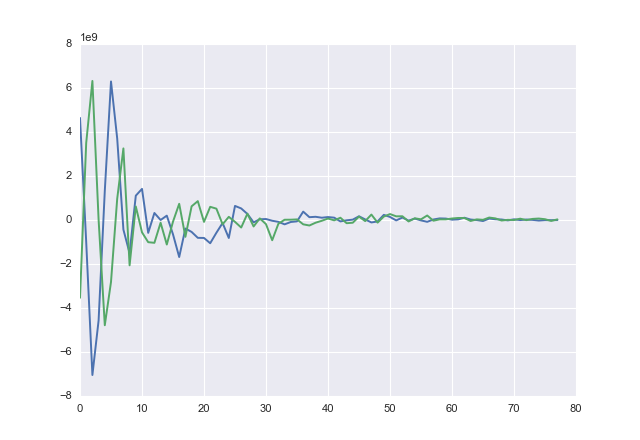

In [22]:
%matplotlib notebook
plt.figure()
plt.plot(lda.scalings_)
plt.show()

<IPython.core.display.Javascript object>


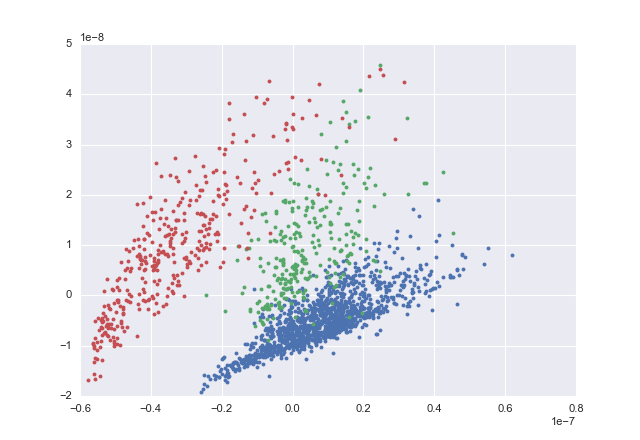

In [23]:
#try with X_flux instead of X
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit(X).transform(X)
%matplotlib notebook
plt.figure()
for j in range(3):
    plt.plot(X_pca[:, 0][y==j], X_pca[:, 1][y==j], '.')
plt.show()

In [12]:
pca.explained_variance_ratio_

array([ 0.76003171,  0.19218943])

<IPython.core.display.Javascript object>


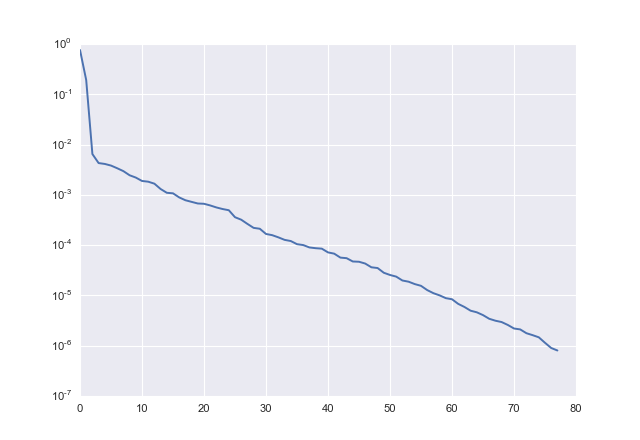

('pca.explained_variance_ratio_', array([  7.60031711e-01,   1.92189432e-01,   6.47849321e-03,
         4.28732549e-03,   4.11910831e-03,   3.82330491e-03,
         3.38200441e-03,   2.96281994e-03,   2.45348154e-03,
         2.20679867e-03,   1.88935954e-03,   1.82805420e-03,
         1.66844560e-03,   1.30762671e-03,   1.09964395e-03,
         1.07287811e-03,   8.89820802e-04,   7.81515101e-04,
         7.25365791e-04,   6.73428080e-04,   6.64771230e-04,
         6.15930558e-04,   5.62004913e-04,   5.22684754e-04,
         4.94783153e-04,   3.59415179e-04,   3.20675641e-04,
         2.64607807e-04,   2.20640577e-04,   2.11785186e-04,
         1.66926512e-04,   1.57908172e-04,   1.42790934e-04,
         1.27342514e-04,   1.20674966e-04,   1.04545127e-04,
         1.00393414e-04,   8.99785662e-05,   8.69891739e-05,
         8.51501794e-05,   7.17542124e-05,   6.77229975e-05,
         5.64929306e-05,   5.50585693e-05,   4.73186485e-05,
         4.67425019e-05,   4.30376965e-05,   3.6276

In [24]:
from sklearn.decomposition import PCA
pca = PCA(n_components=None)
X_pca = pca.fit(X).transform(X)
plt.figure()
print('pca.explained_variance_ratio_', pca.explained_variance_ratio_)
#df = pd.DataFrame(X_pca, columns=['1','2','3'])
#df['y'] = pd.Series(y).astype("category")
#scatter_matrix_seaborn(df, y='y', size=3)
#plt.plot(pca.explained_variance_ratio_)
plt.semilogy(pca.explained_variance_ratio_)
plt.show()

<IPython.core.display.Javascript object>


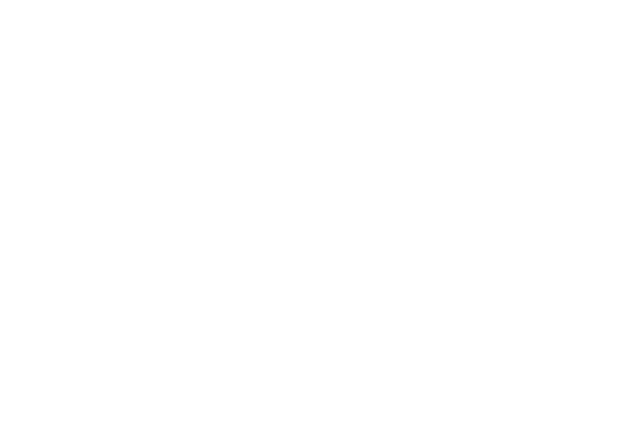

In [14]:
#pca.components_
plt.figure()
plt.plot(pca.components_[:3].T)
plt.show()

In [15]:
#nmf:

from sklearn.decomposition import NMF
Xpos = X - X.min(axis=0)
model = NMF(n_components=2, init='random', random_state=0)
model.fit(Xpos) 
X_nmf = model.transform(Xpos)
for j in range(3):
    plt.plot(X_nmf[:, 0][y==j], X_pca[:, 1][y==j], '.')
plt.show()
print 'model.reconstruction_err_', model.reconstruction_err_
#print 'model.components_', model.components_

model.reconstruction_err_ 2.7678887208e-07


<IPython.core.display.Javascript object>


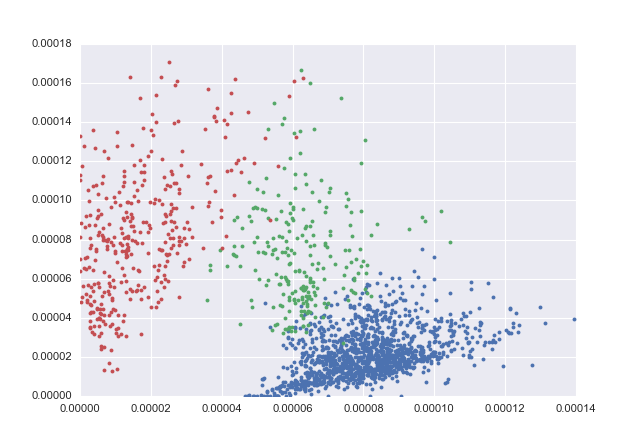

In [16]:
model = NMF(n_components=2, init='random', random_state=0)
%matplotlib notebook
plt.figure()
model.fit(Xpos)
X_nmf = model.transform(Xpos)
for j in range(3):
    plt.plot(X_nmf[:, 0][preds==j], X_nmf[:, 1][preds==j], '.')#, c='k')
plt.show()

<IPython.core.display.Javascript object>


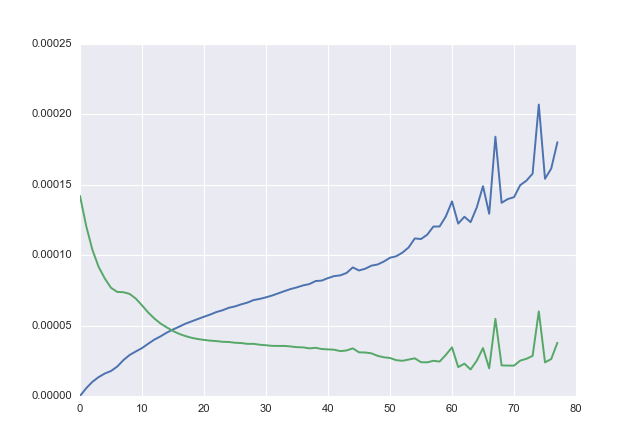

In [17]:
plt.figure()
plt.plot(model.components_.T)
plt.show()

<IPython.core.display.Javascript object>


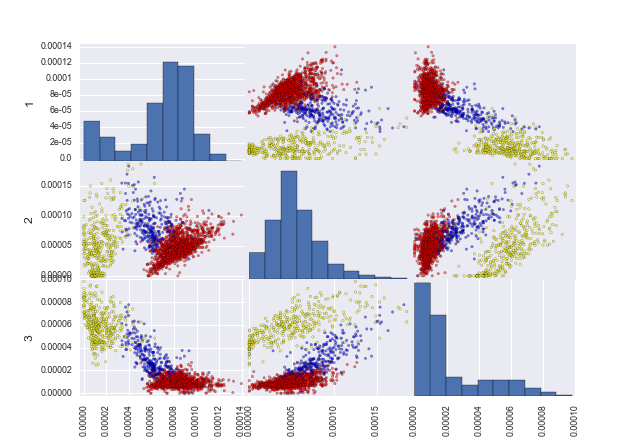

model.reconstruction_err_ 2.20048834014e-07


In [18]:
model = NMF(n_components=3, init='random', random_state=0)
model.fit(Xpos)

colors = ['red', 'blue', 'yellow']

X_nmf = model.transform(Xpos)
df = pd.DataFrame(X_nmf, columns=['1','2', '3'])
df['y'] = pd.Series(y).astype("category")
#scatter_matrix_seaborn(df, y='y', size=3)

from pandas.tools.plotting import scatter_matrix
col = [colors[x] for x in df['y']]
scatter_matrix(df, c=col)#, alpha=0.2, figsize=(6, 6), diagonal='kde')


print 'model.reconstruction_err_', model.reconstruction_err_
#print 'model.components_', model.components_

<IPython.core.display.Javascript object>


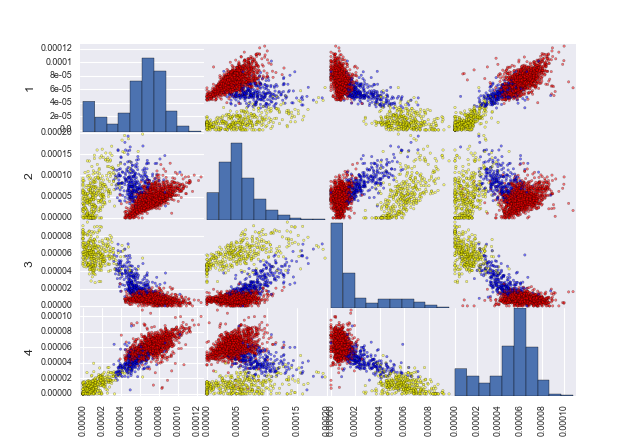

model.reconstruction_err_ 2.10473079558e-07


In [19]:
model = NMF(n_components=4, init='random', random_state=0)
model.fit(Xpos) 
X_nmf = model.transform(Xpos)
df = pd.DataFrame(X_nmf, columns=['1','2', '3', '4'])
df['y'] = pd.Series(y).astype("category")

from pandas.tools.plotting import scatter_matrix
col = [colors[x] for x in df['y']]
scatter_matrix(df, c=col)#, alpha=0.2, figsize=(6, 6), diagonal='kde')

#scatter_matrix_seaborn(df, y='y', size=3)
print 'model.reconstruction_err_', model.reconstruction_err_
#print 'model.components_', model.components_

<IPython.core.display.Javascript object>


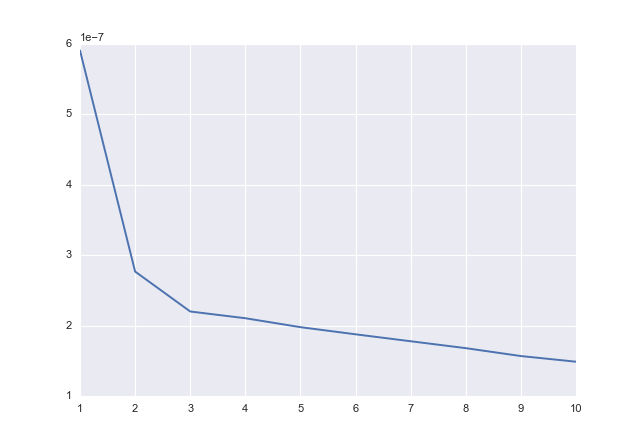

In [20]:
err = []
n_comps = range(1, 11)
for n_comp in n_comps:
    model = NMF(n_components=n_comp, init='random', random_state=0)
    model.fit(Xpos) 
    err += [model.reconstruction_err_]
plt.figure()
plt.plot(n_comps, err)